<a href="https://colab.research.google.com/github/chinyemba/Sales-Forecasting-using-Facebook-Prophet-ARIMA/blob/master/Time_Series_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Analysis - Walmart Sales Dataset

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
from  IPython.display import display, HTML, display_html
import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Read Data

In [0]:
os.listdir(os.getcwd())

['.config', 'walmart.csv', 'sample_data']

In [0]:

data = pd.read_csv('walmart.csv')
data['sales'] = data.Weekly_Sales
data['date'] = data.Date

data.head(5)

,Unnamed: 0,Date,Weekly_Sales,sales,date
0,1,2010-02-05,24924.50,24924.50,2010-02-05
1,2,2010-02-12,46039.49,46039.49,2010-02-12
2,3,2010-02-19,41595.55,41595.55,2010-02-19
3,4,2010-02-26,19403.54,19403.54,2010-02-26
4,5,2010-03-05,21827.90,21827.90,2010-03-05


In [0]:

data = data.drop('Unnamed: 0', axis = 1)
data = data.drop('Date', axis = 1)
data = data.drop('Weekly_Sales', axis = 1)
#data = data.drop('index', axis=1)
#data = data.drop('Dept', axis=1)
#data = data.drop('IsHoliday', axis=1)
#data = data.drop('Store', axis=1)


In [0]:
data.head()

,sales,date
0,24924.50,2010-02-05
1,46039.49,2010-02-12
2,41595.55,2010-02-19
3,19403.54,2010-02-26
4,21827.90,2010-03-05


In [0]:
data.describe()

,sales
count,421570.000000
mean,15981.258124
std,22711.183523
min,-4988.940000
25%,2079.650000
50%,7612.030000
75%,20205.852500
max,693099.360000


In [0]:
data.shape

(421570, 2)

In [0]:
data.describe()

,sales
count,421570.000000
mean,15981.258124
std,22711.183523
min,-4988.940000
25%,2079.650000
50%,7612.030000
75%,20205.852500
max,693099.360000


## Group Data 

In [0]:

data = data.groupby(by = 'date').agg({'sales': 'sum'}) #alternate with 'counts'
data.index = pd.to_datetime(data.index) # dates to date time format
#data = data.asfreq(freq = '1D')

In [0]:
data = data.sort_index(ascending = True)
data = data.fillna(value = 0)

In [0]:
data

,sales
date,
2010-02-05,49750740.56
2010-02-12,48336677.65
2010-02-19,48276993.74
2010-02-26,43968571.02
2010-03-05,46871470.36
...,...
2012-09-28,43734899.44
2012-10-05,47566639.48
2012-10-12,46128514.37


##Plot the Dataset

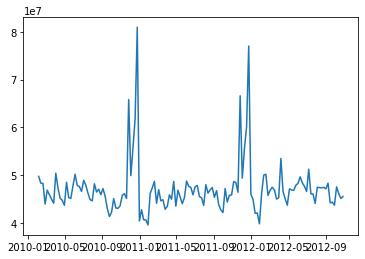

In [0]:
f, ax = plt.subplots(1,1)
ax.plot(data['sales'])

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

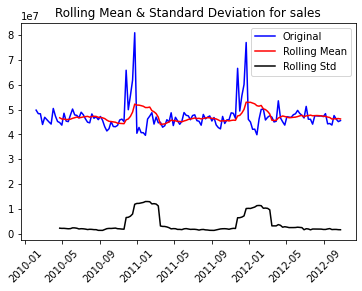

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
# Lags Used                    4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [0]:
test_stationarity(df = data, ts = 'sales')

##Data Transformations

In [0]:
#function to plot transformed data
def plot_transform(df, ts, ts_transform):
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

In [0]:
#log transformation

In [0]:
def log_trans(df, ts): return df[ts].apply(lambda x:np.log(x))

In [0]:
data['sales_log'] = data['sales'].apply(lambda x:np.log(x))

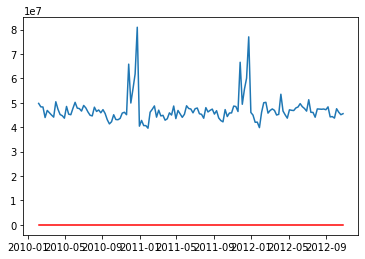

In [0]:
plot_transform(data, 'sales', 'sales_log')

##Differentiating and Transformations

In [0]:
data['sales_moving_avg'] = data['sales'].rolling(window =7 , center= False).mean() #Moving Average
data['sales_log_diff'] = data['sales_log'].diff() #Logarithmic transformation
data['sales_moving_avg_diff'] = data['sales']-data['sales_moving_avg'] #Moving Average Differentating
data['sales_log_ewma']=data['sales_log'].ewm(halflife =7, ignore_na =False,min_periods=0, adjust=True).mean() #Logarithmic Exponential Weighted Moving Average
data['sales_log_ewma_diff']=data['sales_log']-data['sales_log_ewma'] #Log Exponential Moving Average Differentiation

data_trans=data.dropna()

In [0]:
data_trans['sales_log_ewma']=data_trans['sales_log'].ewm(halflife =7, ignore_na =False,min_periods=0, adjust=True).mean() 
data_trans['sales_log_ewma_diff']=data_trans['sales_log']-data_trans['sales_log_ewma']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


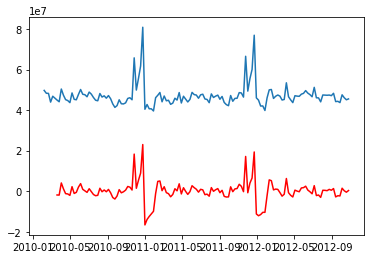

In [0]:
plot_transform(data, 'sales','sales_moving_avg_diff')

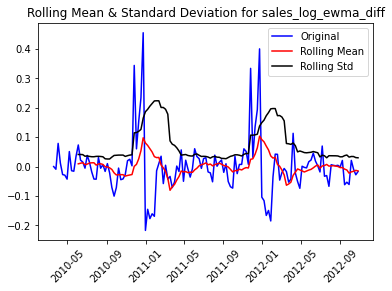

Results of Dickey-Fuller Test:
Test Statistic                -6.489575e+00
p-value                        1.236279e-08
# Lags Used                    4.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


In [0]:
test_stationarity(data_trans, 'sales_log_ewma_diff')

### **Decomposition Analysis**

In [0]:
def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


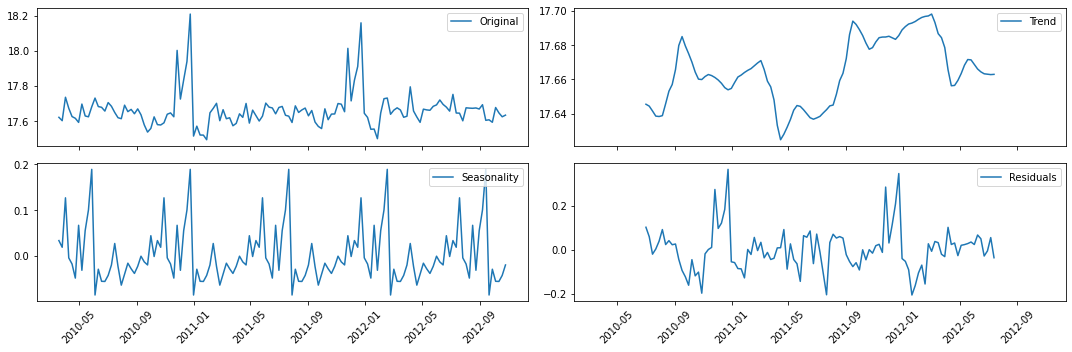

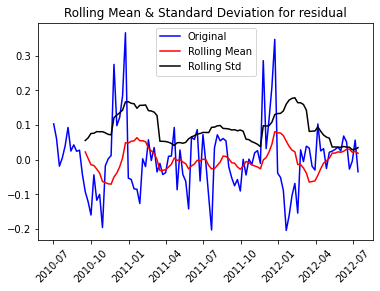

Results of Dickey-Fuller Test:
Test Statistic                -5.683796e+00
p-value                        8.368786e-07
# Lags Used                    4.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_trans['sales_log'], freq = 30)

data_trans.loc[:,'trend'] = decomposition.trend
data_trans.loc[:,'seasonal'] = decomposition.seasonal
data_trans.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = data_trans, ts= 'sales_log',trend='trend', seasonal='seasonal',residual='residual')

test_stationarity(data_trans.dropna(), ts='residual')

In [0]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


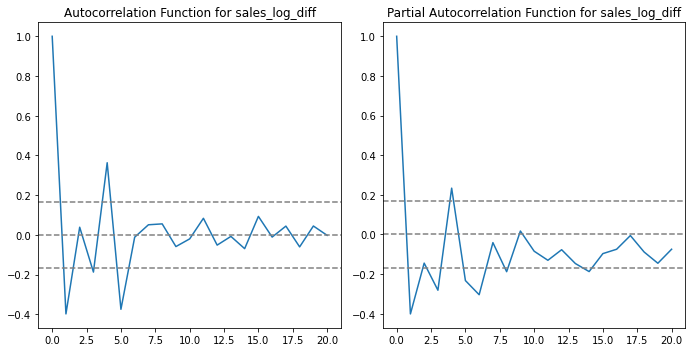

In [0]:

from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(np.array(data_trans['sales_log_diff']),nlags=20)
lag_pacf=pacf(np.array(data_trans['sales_log_diff']),nlags=20)

plot_acf_pacf(df=data_trans, ts= 'sales_log_diff')

##ARIMA

In [0]:
from statsmodels.tsa.arima_model import ARIMA

In [0]:
def run_arima(df,ts,p,d,q):
  
  model=ARIMA(df[ts], order=(p,d,q))
  results_arima=model.fit(disp=-1)

  len_results = len(results_arima.fittedvalues)
  ts_modified = df[ts][-len_results:]

  rss  = sum((results_arima.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss/ len(df[ts]))

  plt.figure()
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color='red')

  plt.show()

  return results_arima


##Run ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



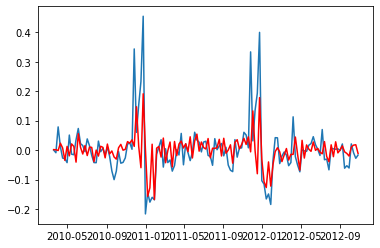

In [0]:
model_ARIMA = run_arima(df= data_trans, ts='sales_log_ewma_diff',p=3,d=0,q=3)

##Facebook Prophet (Time Series)

In [0]:
#!pip install pystan
#!pip install gcc
#!pip install prophet
#conda install -c conda-forge fbprophet

In [0]:
from fbprophet import Prophet
import datetime
from datetime import datetime
from fbprophet.diagnostics import cross_validation

In [0]:
import sys
print(sys.executable)

/usr/bin/python3


In [0]:
def days_between(d1,d2):
  d1 = datetime.strptime(d1, "%Y-%m-%d")
  d2 = datetime.strptime(d2, "%Y-%m-%d")
  
  return abs((d2-d1).days + 1 )

In [0]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = data
start_training_date = '2010-01-01'
end_training_date = '2012-10-26'
start_forecasting_date = '2012-10-27'
end_forecasting_date = '2013-11-30'
year_to_estimate = '2013'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True

In [0]:
df_prophet = data_trans[['sales_log_ewma']]
df_prophet= df_prophet.reset_index()
df_prophet = df_prophet.rename(columns = {'date':'ds','sales_log_ewma':'y'})
df_prophet['ds']=pd.to_datetime(df_prophet['ds'])
df_prophet['y']=pd.to_numeric(df_prophet['y'], errors='ignore')

In [0]:
def daily_forecast(df,holidays,growth,n_changepoints=25,holidays_prior_scale=10,changepoint_prior_scale =0.05,
                   changepoints=None,interval_width =0.8, mcmc_samples=1, future_num_points =10, daily_seasonality =True):
  df_c=df.copy()
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality)
  m.fit(df_c)
  future = m.make_future_dataframe(periods =future_num_points)
  forecst = m.predict(future)

  m.plot(forecst);
  m.plot_components(forecst)

  return forecst


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


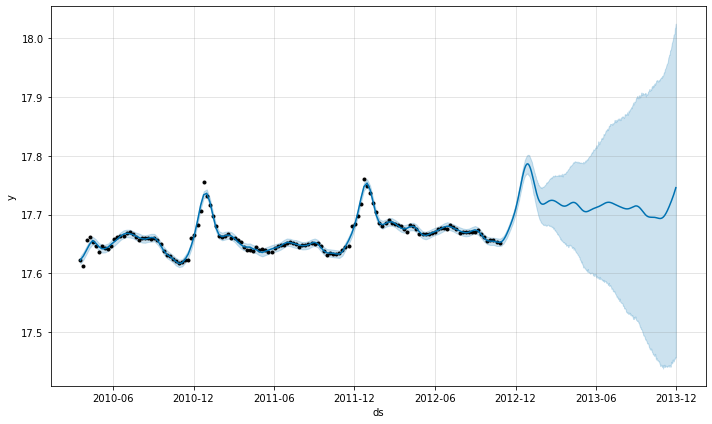

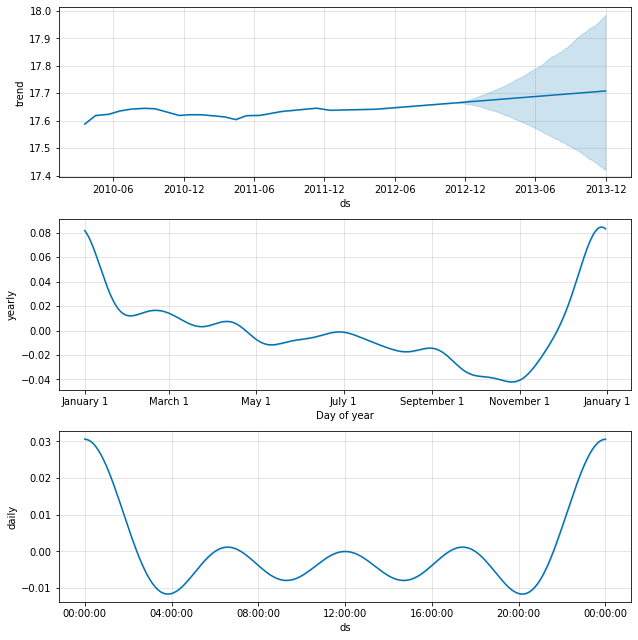

In [0]:
forecst=daily_forecast(df_prophet,holidays,growth,n_changepoints,holidays_prior_scale,
                       changepoint_prior_scale,changepoints,interval_width,mcmc_samples,future_num_points,daily_seasonality)

##Calculate Metrics

In [0]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return


In [0]:
print_error_metrics(y_true=df_prophet['y'], y_pred=forecst['yhat'])

MAPE: 0.017292
MPE: -0.000009
MAE: 0.305549
RMSE: 0.004716


#LSTM ANN for Time Series

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential as Sequential
from keras.layers import Dense as Dense
from keras.layers import LSTM as LSTM

def ts_lstm_model(df, sales, look_back, epochs, type_ = None, train_fraction = 0.67):

  def create_dataset(dataset, look_back = 1):

    X, Y =[],[]
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      X.append(a)
      Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

  np.random.seed(7)
  dataset = df['sales'].values.astype('float32')

  scaler = MinMaxScaler(feature_range = (0,1))
  dataset = scaler.fit_transform(dataset.reshape(-1,1))
  

  train_size = int(len(dataset) * train_fraction)
  test_size  = len(dataset) - train_size


  train = dataset[:train_size,:]
  test  = dataset[train_size:,:]

  look_back =look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)


  if type_ == 'regresion with time steps':
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
  elif type_ == 'stacked with memory between between batches':
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
  else: 
    trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
    testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

  # LSTM Creation
  batch_size = 1
  model = keras.Sequential()

  if type_=='regression with time steps':
    model.add(tf.keras.layers.LSTM(20,input_shape=(look_back,1)))
  elif type_ =='memory between batches':
    model.add(tf.keras.layers.LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateteful = True))
  elif  type_=='stacked with memory between batches':
    model.add(tf.keras.layers.LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(tf.keras.layers.LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(tf.keras.layers.LSTM(20, input_shape = (1, look_back)))

  model.add(tf.keras.layers.Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')

  model.summary()

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
      for i in range(100):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
  else:
      model.fit(trainX, 
                trainY, 
                epochs = epochs, 
                batch_size = 1, 
                verbose = 1)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
  plt.figure()
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 4,901
Trainable params: 4,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 7/50
50/50 [======================

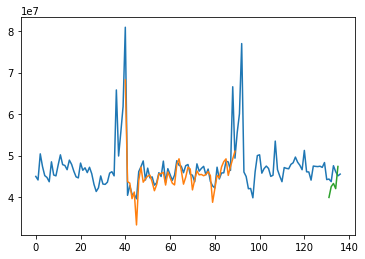

In [0]:
lstm = ts_lstm_model(data_trans, data_trans['sales_log_ewma_diff'], look_back=40, epochs=50)